In [2]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

sns.set_palette('Set1')


In [3]:
np.array(plt.colormaps['Set1'](1)) * 255

array([ 55., 126., 184., 255.])

In [4]:
def hist_equalize(matrix):
    matrix = np.copy(matrix)
    shape = matrix.shape
    matrix = matrix.reshape(-1)
    index = matrix.argsort()
    values = np.linspace(0, 1, index.shape[0])
    matrix[index] = values
    return matrix.reshape(shape)

def mkrdm(data):
    rdmat = 1 - cosine_similarity(data)
    return rdmat

def mkherdm(data):
    rdmat = 1 - cosine_similarity(data)
    return hist_equalize(rdmat)



In [5]:
def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

itc = movavg(np.load('G:\Data\Fast\Both\ITCNoAvg.npy'), 25, 1)
pfc = movavg(np.load('G:\Data\Fast\Both\PFCNoAvg.npy'), 25, 1)

In [6]:
rdm_data = {}
for region, attr in zip(['itc', 'pfc'], [itc, pfc]):
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])
    herdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])

    for itime in range(attr.shape[2]):
        rdmat[:,:,itime] = mkrdm(attr[argsort, :, itime])
        herdmat[:,:,itime] = mkherdm(attr[argsort, :, itime])

    rdm_data[region] = {'raw': rdmat, 'histeq': herdmat}

# CORNet-Z

In [21]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-Z_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

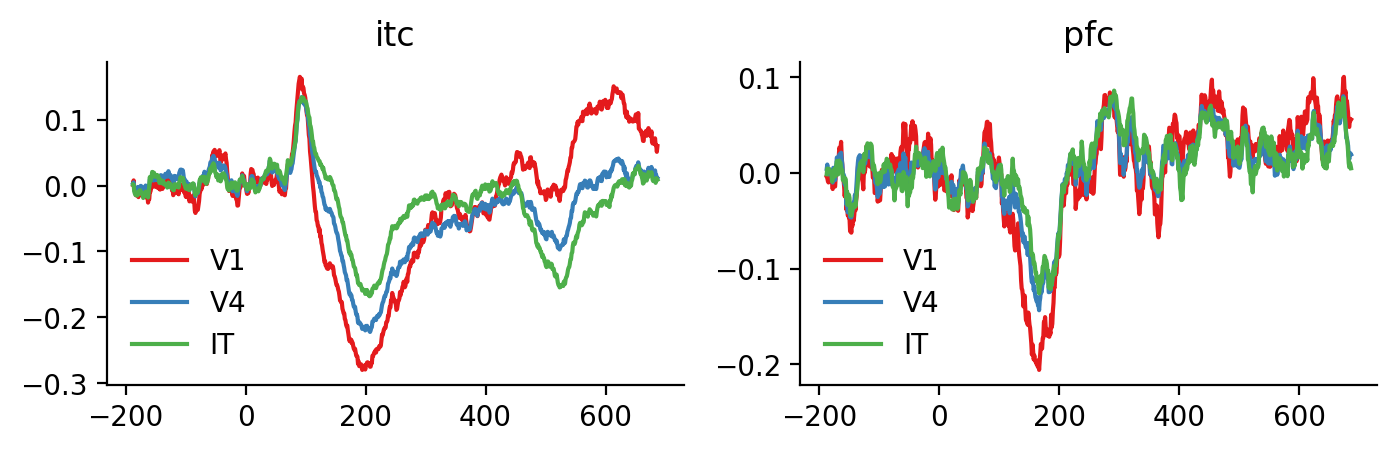

In [24]:
from scipy.stats import kendalltau as tau
from scipy.stats import pearsonr as p
from scipy.stats import spearmanr as r

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5

for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in ['V1', 'V4', 'IT']: #rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(p(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        ax.plot(tim, _s-_s[(tim >= -25) & (tim < 25)].mean(), label=cnet)
        # ax.plot(tim, _s, label=cnet)
    ax.set_title(region)
    ax.legend(frameon=False)
fig.tight_layout()
sns.despine()

plt.savefig('z-p.pdf')

# CORNet-S

In [7]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-S_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

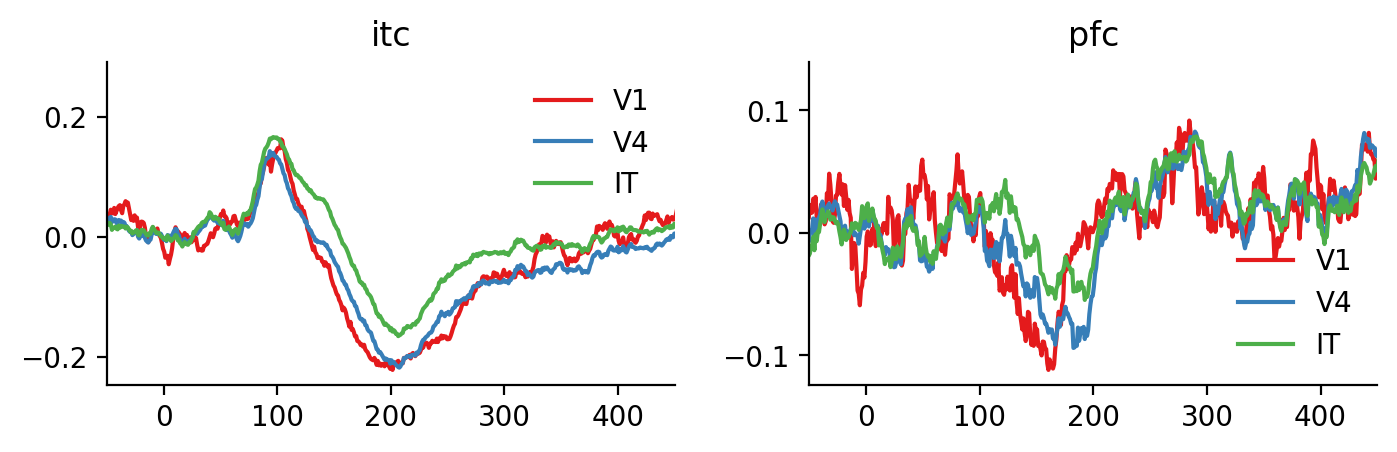

In [20]:
from scipy.stats import kendalltau as tau
from scipy.stats import pearsonr as p
from scipy.stats import spearmanr as r

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5


for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in ['V1', 'V4', 'IT']: #rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(p(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        ax.plot(tim, _s-_s[(tim >= -25) & (tim < 25)].mean(), label=cnet)
        ax.set_xlim(-50, 450)
    ax.set_title(region)
    ax.legend(frameon=False)

sns.despine()
fig.tight_layout()

plt.savefig('s-p.pdf')

In [11]:
_s[(tim >= -50) & (tim < 0)]

array([-0.03737799, -0.03987597, -0.03209097, -0.02104968, -0.0409841 ,
       -0.02768275, -0.03424838, -0.02476243, -0.01896257, -0.01033721,
       -0.00464286,  0.01461911,  0.00469318, -0.00168977,  0.01139053,
        0.01742966,  0.0186075 ,  0.01515018,  0.01936702,  0.02255852,
        0.01365084,  0.01340308,  0.00721627,  0.00637201,  0.00736422,
        0.00010427, -0.00884714, -0.01420337, -0.01677599,  0.01099726,
        0.01379171,  0.01046739,  0.00627529,  0.01262948,  0.00950293,
        0.01393901,  0.01364813,  0.02400614,  0.01259174,  0.00562882,
        0.01023242,  0.00907234,  0.00767041,  0.00832847,  0.02276566,
        0.03528056,  0.04792882,  0.04199008,  0.0261526 ,  0.03023467])

In [72]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-S_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "BL"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

In [73]:
rdm_data = {}
for region, attr in zip(['itc', 'pfc'], [itc, pfc]):
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & (info.sfr == "BL")).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])
    herdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])

    for itime in range(attr.shape[2]):
        rdmat[:,:,itime] = mkrdm(attr[argsort, :, itime])
        herdmat[:,:,itime] = mkherdm(attr[argsort, :, itime])

    rdm_data[region] = {'raw': rdmat, 'histeq': herdmat}

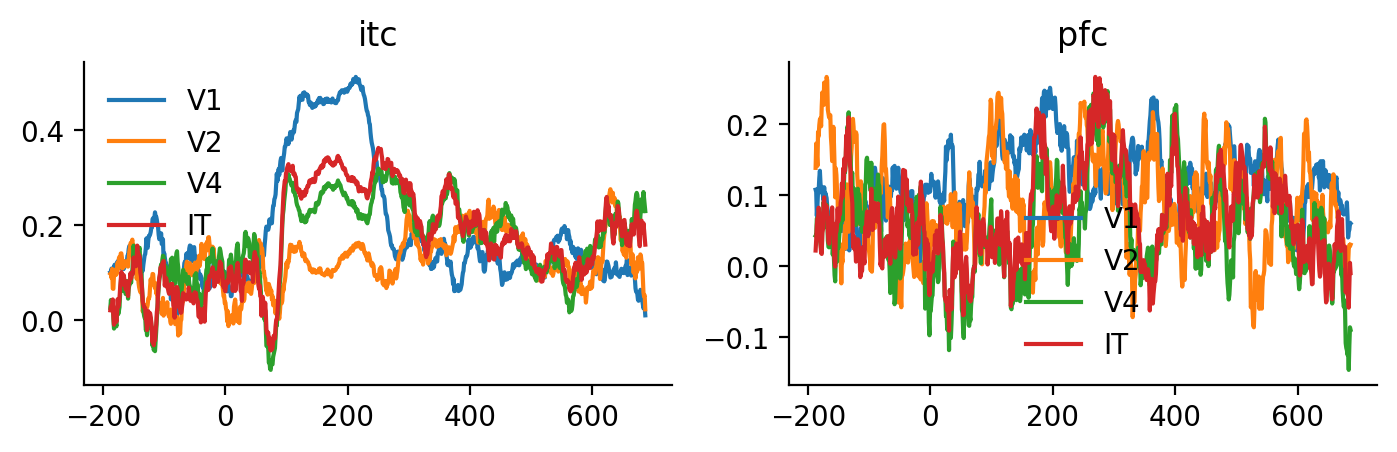

In [74]:
from scipy.stats import kendalltau as tau

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5

for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(tau(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        ax.plot(tim, _s, label=cnet)
    ax.set_title(region)
    ax.legend(frameon=False)
fig.tight_layout()
sns.despine()

In [75]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-S_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "BH"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

In [76]:
rdm_data = {}
for region, attr in zip(['itc', 'pfc'], [itc, pfc]):
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & (info.sfr == "BH")).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])
    herdmat = np.nan * np.ones([argsort.size, argsort.size, attr.shape[2]])

    for itime in range(attr.shape[2]):
        rdmat[:,:,itime] = mkrdm(attr[argsort, :, itime])
        herdmat[:,:,itime] = mkherdm(attr[argsort, :, itime])

    rdm_data[region] = {'raw': rdmat, 'histeq': herdmat}

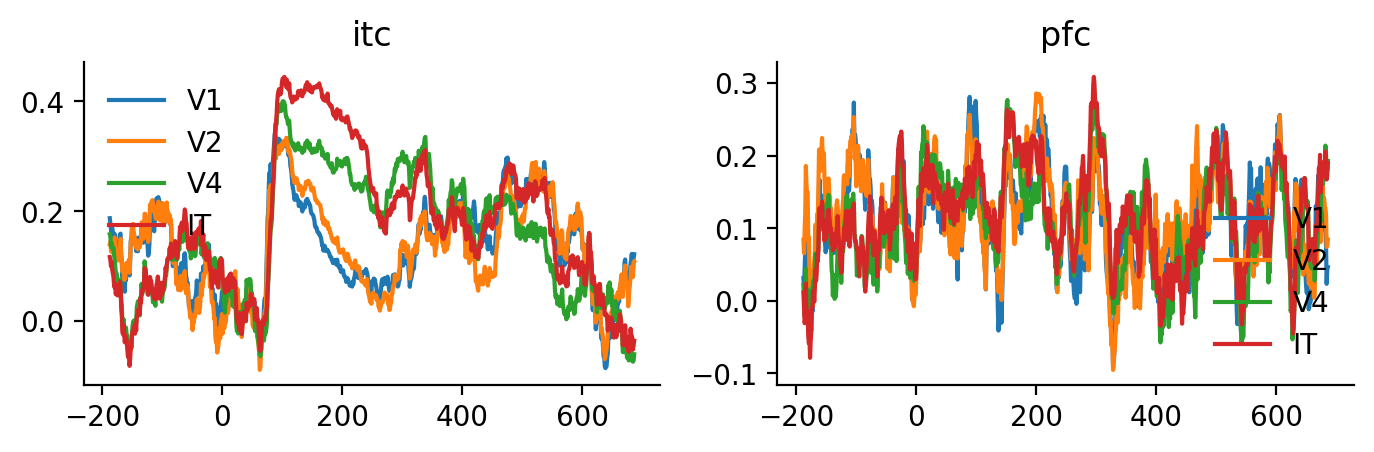

In [77]:
from scipy.stats import kendalltau as tau

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5

for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(tau(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        ax.plot(tim, _s, label=cnet)
    ax.set_title(region)
    ax.legend(frameon=False)
fig.tight_layout()
sns.despine()

# CORNet-RT

In [25]:
rdm_cornet = {}
for region in ['V1', 'V2', 'V4', 'IT']:
    attr = np.load(f'CORnet-RT_{region}_output_feats.npy')
    attr = attr[:165, :]
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]

    validStimuliIndex = ((info.cat != 'none') & ((info.sfr == "A") | (info.sfr == "BI"))).to_numpy()
    attr = attr[validStimuliIndex, :]
    info = info[validStimuliIndex].reset_index(drop=True)

    argsort = np.argsort(info.cat).to_numpy()
    rdmat = mkrdm(attr[argsort, :])
    herdmat = mkherdm(attr[argsort, :])

    rdm_cornet[region] = {'raw': rdmat, 'histeq': herdmat}

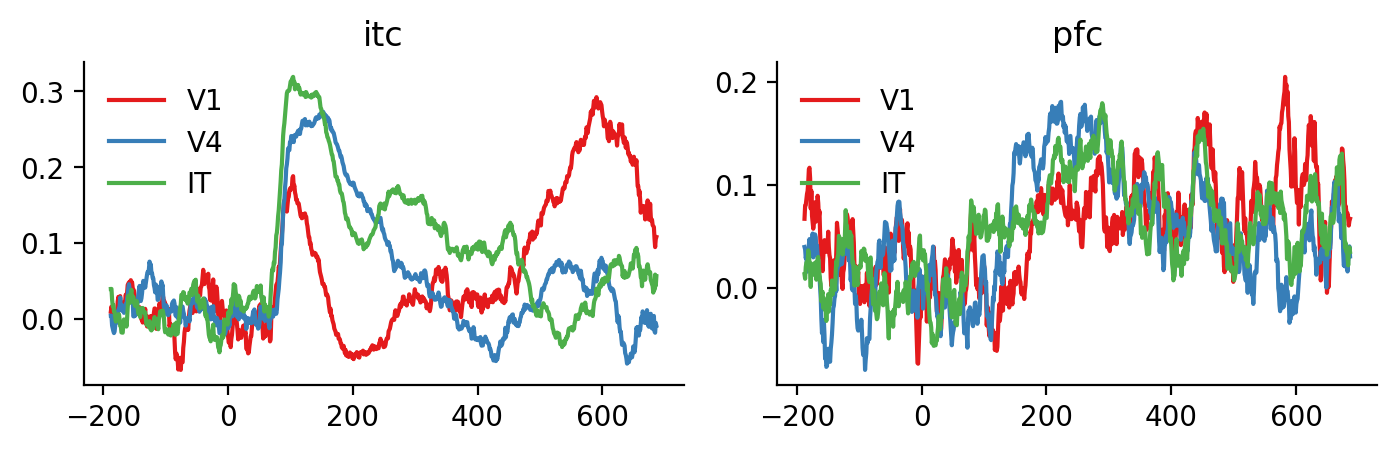

In [30]:
from scipy.stats import kendalltau as tau
from scipy.stats import pearsonr as p
from scipy.stats import spearmanr as r

cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(18 * cm , 6 * cm), dpi=200)

tim = np.arange(-200, 675) + 12.5

for ax, region in zip(axs.flat, rdm_data.keys()):
    for cnet in ['V1', 'V4', 'IT']: #rdm_cornet.keys():
        X = rdm_data[region]['raw']
        y = rdm_cornet[cnet]['raw']

        _s = []
        for time in range(X.shape[2]):
            _s.append(tau(X[:, :, time].flatten(), y.flatten())[0])
        _s = np.array(_s)

        # ax.plot(tim, _s, label=cnet)
        ax.plot(tim, _s-_s[(tim >= -25) & (tim < 25)].mean(), label=cnet)
    ax.set_title(region)
    ax.legend(frameon=False)
fig.tight_layout()
sns.despine()

plt.savefig('rt-tau.pdf')